Oversampling > 2x suggested for reliable results in Fresnel propagation.


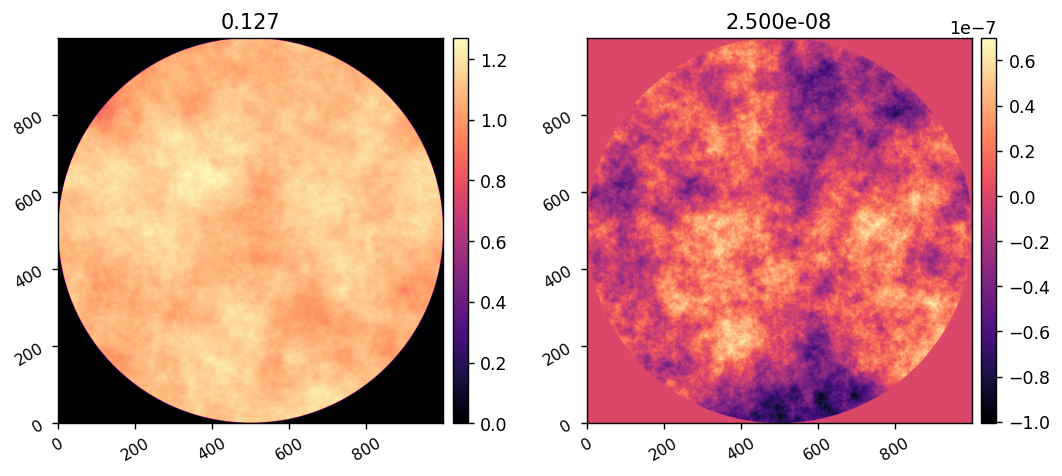

array(2.5e-08)

In [1]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

from matplotlib.patches import Circle
from importlib import reload

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoob_fraunhofer as scoob
import scoobpsf.psds as psds

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])


Oversampling > 2x suggested for reliable results in Fresnel propagation.


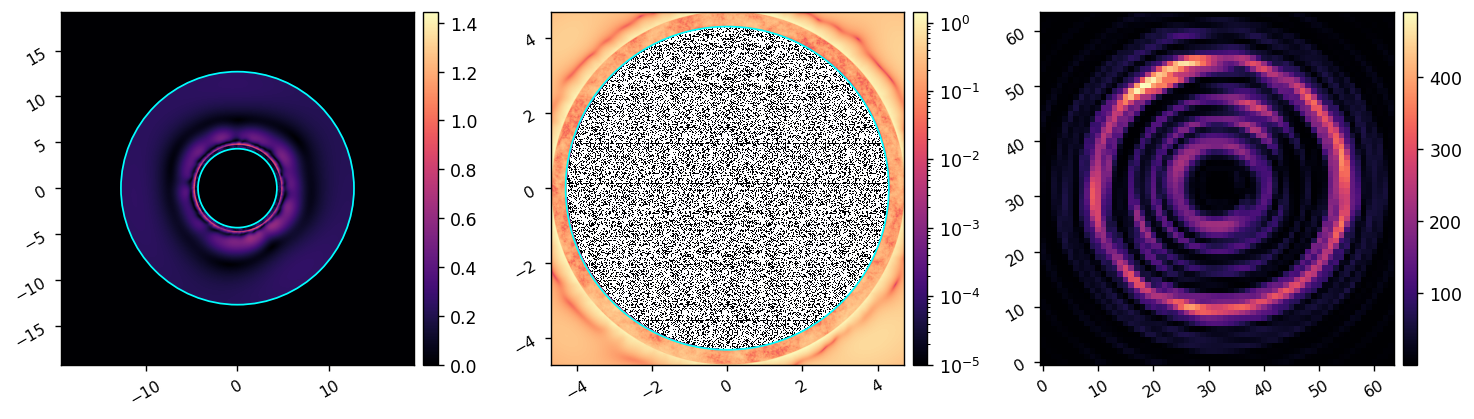

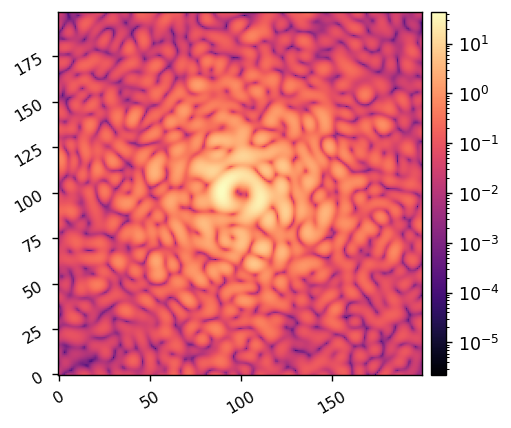

In [2]:
model = scoob.CORO()
model.WFE = WFE
model.use_fpm = True
model.use_llowfsc()
model.llowfsc_fl = 200*u.mm

wfs = model.calc_wfs()
llowfsc_im = xp.abs(wfs[-1])**2

# imshow1(im)
imshow3(xp.abs(wfs[-2]), xp.abs(wfs[-2]), llowfsc_im, npix2=model.npix, lognorm2=True, vmin2=1e-5, 
        pxscl1=model.lyot_pupil_diam/model.npix, pxscl2=model.lyot_pupil_diam/model.npix,
        patches1=[Circle((0,0), 8.6/2, fill=False, color='cyan'),
                  Circle((0,0), 25.4/2, fill=False, color='cyan'),],
        patches2=[Circle((0,0), 8.6/2, fill=False, color='cyan'),],
                  )

model.use_llowfsc(False)
coro_im = model.snap()
imshow1(coro_im, lognorm=True)

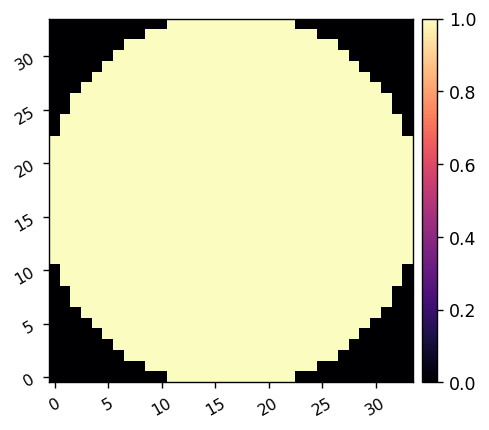

array(952)

In [3]:
dm_mask = xp.ones((model.Nact,model.Nact), dtype=bool)
xx = (xp.linspace(0, model.Nact-1, model.Nact) - model.Nact/2 + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(model.Nact+1)/2] = 0
imshow1(dm_mask)
dm_mask.sum()

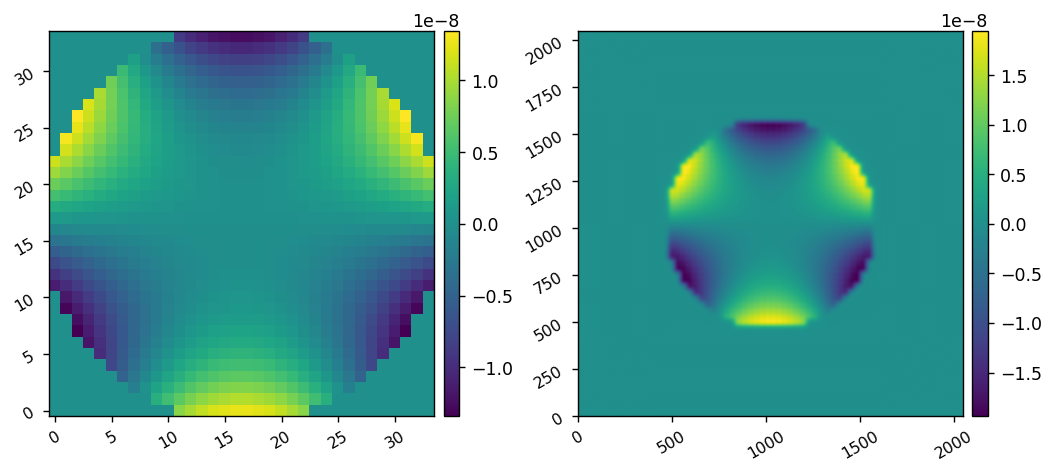

In [4]:
dm_zernikes = lina.utils.create_zernike_modes(dm_mask, nmodes=25 + 1)[1:]
model.set_dm(dm_zernikes[7]*5e-9)
imshow2(dm_zernikes[7]*5e-9, model.DM.get_surface(), cmap1='viridis', cmap2='viridis')
model.reset_dm()


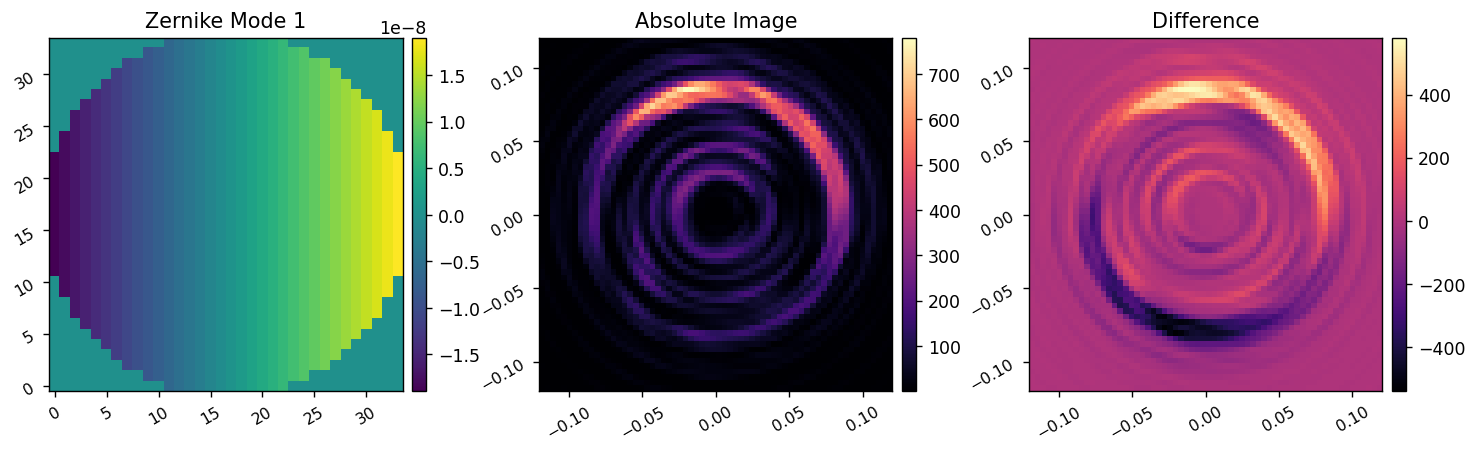

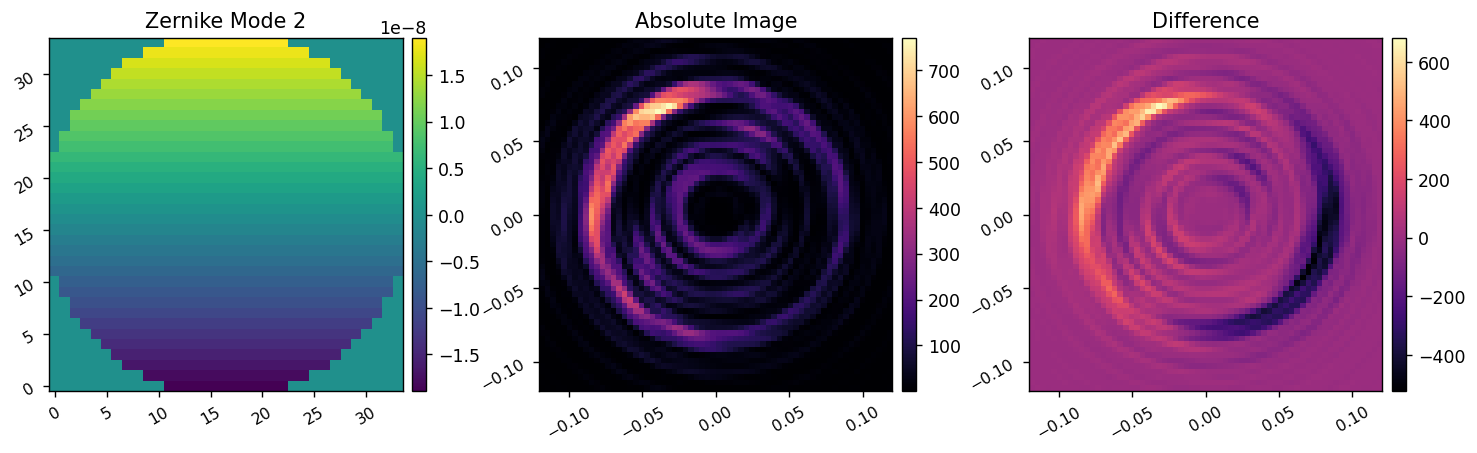

In [5]:
amp = 10e-9

model.use_llowfsc()

model.reset_dm()
model.WFE = WFE

im_ref = model.snap()

N = 2
responses = xp.zeros((N, model.nllowfsc**2))
for i in range(N):
    mode = dm_zernikes[i]
    # model.RETRIEVED = poppy.ArrayOpticalElement(opd=mode*1e-8, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
    # im_pos = model.snap()

    model.set_dm(amp*mode)
    im_pos = model.snap()
    model.add_dm(-amp*mode)
    
    # diff = im_pos-im_ref
    # responses[i] = diff.flatten()/amp
    
    model.add_dm(-amp*mode)
    im_neg = model.snap()
    model.add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+1}', 'Absolute Image', 'Difference', 
            pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix), 
            cmap1='viridis')

response_matrix = responses.T

In [8]:
U, s, Vt = xp.linalg.svd(response_matrix, full_matrices=False)
s.max()/s.min()

array(1.10602814)

In [6]:
# control_matrix = lina.utils.beta_reg(response_matrix, -10)
control_matrix = lina.utils.TikhonovInverse(response_matrix, 0)

# load in the low-order WFE time series

In [7]:
initial_jitter = 50*u.mas
dm_pupil_diam = 9.4*u.mm
total_pupil_diam = 2.4*u.m
tt_pv_to_rms = 1/4

# Recreating Chris's tip/tilt conversion from mas to nm
# initial_jitter = 96.6*u.mas
# tt_pv_to_rms = 1/4
# total_pupil_diam = 2*u.m

mag = total_pupil_diam.to_value(u.m)/dm_pupil_diam.to_value(u.m)

tt_at_dm_pupil = mag * initial_jitter
print(tt_at_dm_pupil)

tt_at_dm_pupil_pv = np.tan(tt_at_dm_pupil).value * dm_pupil_diam
print(tt_at_dm_pupil_pv.to(u.nm))

tt_at_dm_pupil_rms = tt_at_dm_pupil_pv * tt_pv_to_rms
print(tt_at_dm_pupil_rms.to(u.nm))


12765.95744680851 mas
581.7764180742765 nm
145.44410451856913 nm


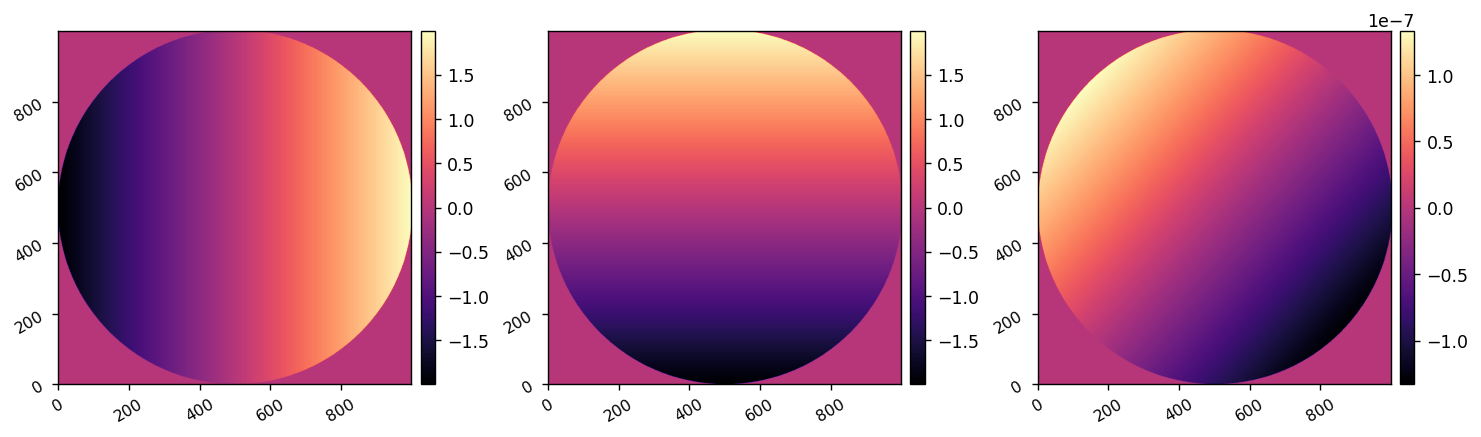

In [8]:
wfe_modes_rms = np.array([100e-9]*2)
# wfe_modes_rms = np.array([10e-9]*2 + [5e-9]*3 + [2.5e-9]*4 + [1e-9]*11)
N_wfe_modes = len(wfe_modes_rms)
wfe_modes = lina.utils.create_zernike_modes(model.APERTURE, nmodes=N_wfe_modes, remove_modes=1)

fmax = 1000*u.Hz
freqs, delF, times = psds.generate_freqs(Nf=2**18+1, f_max=fmax)

wfe_time_series = xp.zeros((N_wfe_modes+1, len(times)))
wfe_time_series[0] = xp.array(times.to_value(u.s))

slope = 4
for i in range(N_wfe_modes):
    if i<2: 
        f_knee = 0.3*u.Hz
    else: 
        f_knee = 0.05*u.Hz
    psd = psds.kneePSD(freqs, 1, f_knee, slope)
    coeff = psds.generate_time_series(psd, fmax, rms=1, seed=12345+i)
    wfe_time_series[i+1] = wfe_modes_rms[i] * xp.array(coeff)

start_i = 0
lo_wfe = wfe_modes.reshape(N_wfe_modes, model.npix**2).T.dot(wfe_time_series[1:,30]).reshape(model.npix, model.npix)
imshow3(wfe_modes[0], wfe_modes[1], lo_wfe)

In [9]:
import threading as th

class Process(th.Timer):  
    def run(self):  
        while not self.finished.wait(self.interval):  
            self.function(*self.args, **self.kwargs)
##We are now creating a thread timer and controling it  
# process = Repeat(0.01,print,['Repeating']) 
# process.start()
# process.cancel()

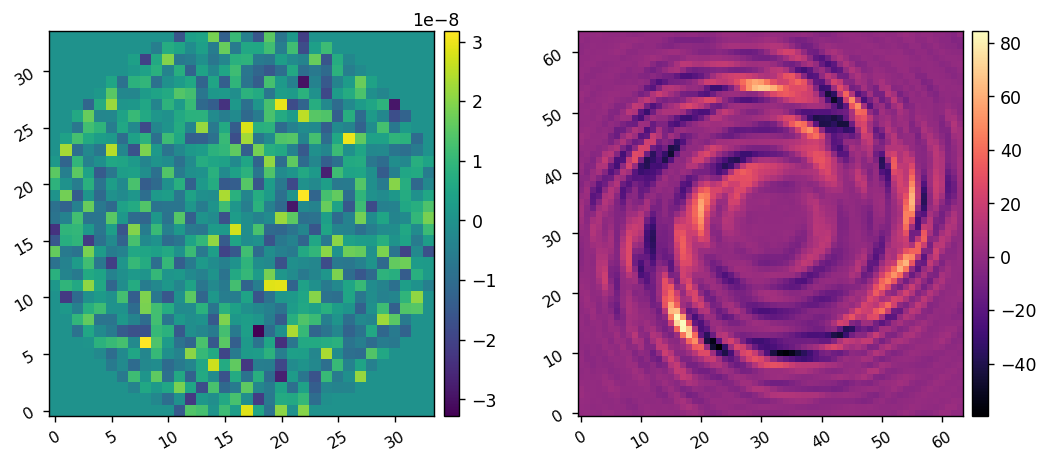

In [39]:
def run_test(M, ref_im, clear=False):
    dm_command = 10e-9 * xp.random.randn(M.Nact,M.Nact) * M.dm_mask
    M.set_dm(dm_command)
    im = M.snap()
    imshow2(dm_command, ref_im - im, cmap1='viridis')
    if clear: clear_output(wait=True)

run_test(model, im_ref)

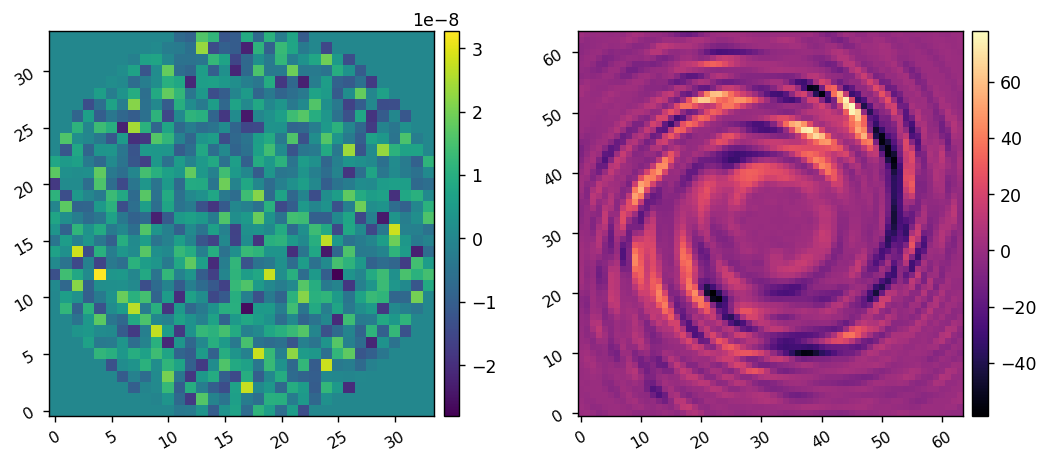

In [42]:
process = Process(0.001,run_test,[model, im_ref, True])
process.start() 

In [44]:
process.cancel()